In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

# Read runtimes from logfiles

In [2]:
from collections import defaultdict
import json
import os
import re


def read_real_system_runtimes(parent_dir):
    runtimes_dict = {}
    denoised_runtimes_dict = {}
    for sub_dir in os.listdir(parent_dir):
        m = re.match(r'(.*),model=([^,]*)(,.*)?', sub_dir)
        if m is not None:
            scenario = m.group(1)
            model = m.group(2)
            if model not in runtimes_dict:
                runtimes_dict[model] = defaultdict(list)
                denoised_runtimes_dict[model] = defaultdict(list)
            
            full_logpath = os.path.join(parent_dir, sub_dir, "per_instance_stats.json")
            try:
                with open(full_logpath, 'r') as f:
                    all_instance_stats = json.load(f)
                    for per_instance_stats in all_instance_stats:
                        stats = per_instance_stats["stats"]
                        inference_runtime = None
                        inference_idealized_runtime = None
                        inference_denoised_runtime = None
                        num_output_tokens = None
                        num_prompt_tokens = None
                        for stat in stats:
                            if stat["name"]["name"] == "inference_runtime":
                                if stat["count"] > 0:
                                    inference_runtime = stat["mean"]
                            elif stat["name"]["name"] == "inference_idealized_runtime":
                                if stat["count"] > 0:
                                    inference_idealized_runtime = stat["mean"]
                            elif stat["name"]["name"] == "inference_denoised_runtime":
                                if stat["count"] > 0:
                                    inference_denoised_runtime = stat["mean"]
                            elif stat["name"]["name"] == "num_output_tokens":
                                if stat["count"] > 0:
                                    num_output_tokens = int(stat["mean"])
                            elif stat["name"]["name"] == "num_prompt_tokens":
                                if stat["count"] > 0:
                                    num_prompt_tokens = int(stat["mean"])
                        if inference_runtime is not None:
                            runtimes_dict[model][(num_prompt_tokens, num_output_tokens)].append(
                                inference_runtime)
                        if inference_denoised_runtime is not None:
                            denoised_runtimes_dict[model][(num_prompt_tokens, num_output_tokens)].append(
                                inference_denoised_runtime)
                    
            except Exception as e:
                print(full_logpath, e)
        
    return runtimes_dict, denoised_runtimes_dict

In [3]:
runtimes_dict, denoised_runtimes_dict = read_real_system_runtimes("../benchmark_output/runs/latest")

In [4]:
runtimes_dict_reduced = {}
denoised_runtimes_dict_reduced = {}
for (output_dict, input_dict) in zip(
    [runtimes_dict_reduced, denoised_runtimes_dict_reduced],
    [runtimes_dict, denoised_runtimes_dict]):
    for model in input_dict:
        output_dict[model] = {}
        for key in input_dict[model]:
            output_dict[model][key] = min(input_dict[model][key])

# Plot runtimes versus idealized runtimes for various models

In [5]:
def plot_runtime_versus_num_output_tokens(runtimes_dict, label,
                                          xlim=None, ylim=None,
                                          model_name=None,
                                          num_prompt_tokens_band=None,
                                          plot_only_minimum=False,
                                          denoised_runtimes_dict=None,
                                          output_filename=None):
    print(label)
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    markers = ['o', '*', '^', 'v', 's', 'D']
    for model in runtimes_dict:
        if model_name is None or model.startswith(model_name):
            if num_prompt_tokens_band is None:
                keys = runtimes_dict[model].keys()
                num_output_tokens = [key[1] for key in keys]
                runtimes = [runtimes_dict[model][key] for key in keys]
                ax.scatter(num_output_tokens,
                           runtimes, marker='o')
            else:
                for i, num_prompt_tokens in enumerate(num_prompt_tokens_band):
                    keys = runtimes_dict[model].keys()
                    num_output_tokens = [key[1] for key in keys
                                         if num_prompt_tokens - 50 <= key[0] <= num_prompt_tokens + 50]
                    runtimes = [runtimes_dict[model][key] for key in keys
                                if num_prompt_tokens - 50 <= key[0] <= num_prompt_tokens + 50]
                    denoised_runtimes = None
                    if denoised_runtimes_dict is not None:
                        keys = denoised_runtimes_dict[model].keys()
                        denoised_num_output_tokens = [
                            key[1] for key in keys
                            if num_prompt_tokens - 50 <= key[0] <= num_prompt_tokens + 50
                        ]
                        denoised_runtimes = [
                            denoised_runtimes_dict[model][key] for key in keys
                            if num_prompt_tokens - 50 <= key[0] <= num_prompt_tokens + 50
                        ]
                    if plot_only_minimum:
                        runtimes_dict_tmp = {}
                        for (x, y) in zip(num_output_tokens, runtimes):
                            if x in runtimes_dict_tmp:
                                runtimes_dict_tmp[x] = min(runtimes_dict_tmp[x], y)
                            else:
                                runtimes_dict_tmp[x] = y
                        num_output_tokens = runtimes_dict_tmp.keys()
                        runtimes = [runtimes_dict_tmp[x] for x in num_output_tokens]
                    ax.scatter(num_output_tokens,
                               runtimes, marker=markers[i % len(markers)],
                               label=f"{num_prompt_tokens}")
                    if denoised_runtimes is not None:
                        x_and_y = list(zip(denoised_num_output_tokens, denoised_runtimes))
                        x_and_y.sort(key=lambda x: x[0])
                        ax.plot([x for (x, y) in x_and_y], [y for (x, y) in x_and_y],
                                linestyle=':')

    ax.set_xlabel("Number of output tokens")
    ax.set_ylabel("Runtime (seconds)")
    ax.set_xlim(0, xlim)
    ax.set_ylim(0, ylim)
    sns.despine()
    
    plt.legend(frameon=False, ncol=2)
    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    plt.show()

All


No handles with labels found to put in legend.


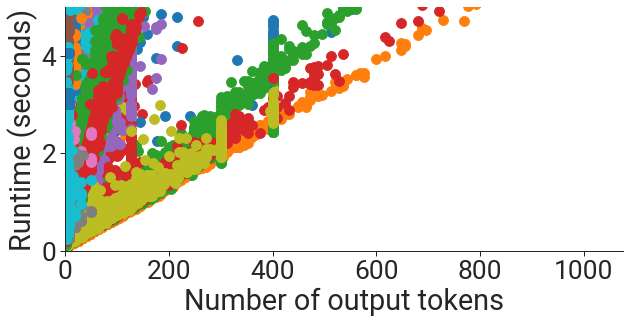

In [6]:
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "All", ylim=5)

AI21/j1-jumbo


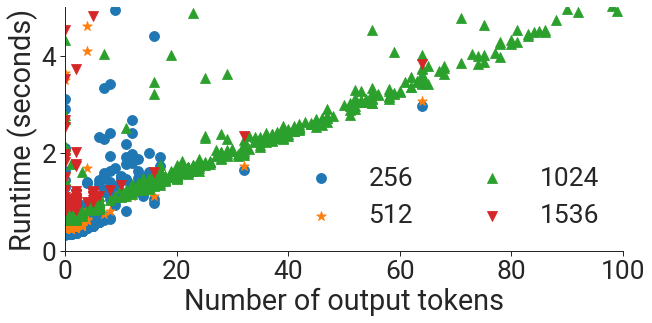

AI21/j1-grande


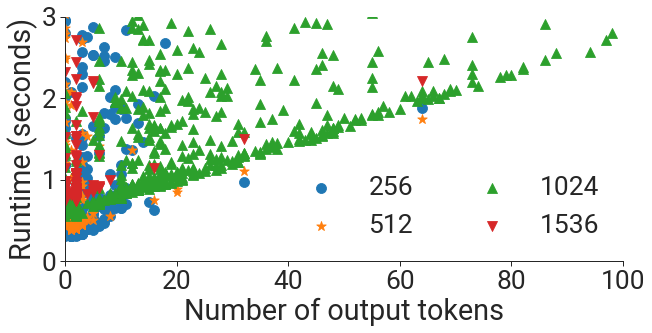

AI21/j1-large


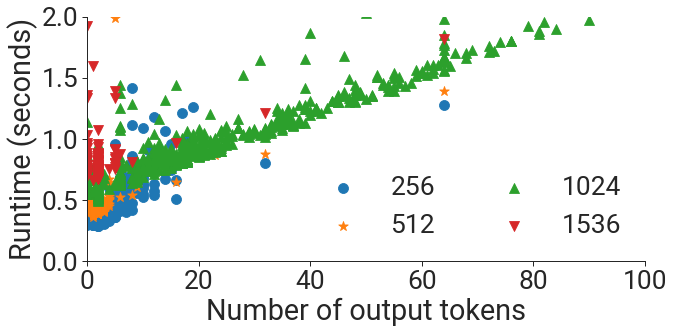

Anthropic


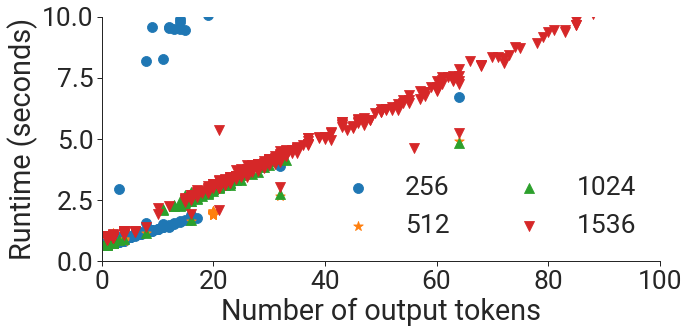

MT-Turing-NLG


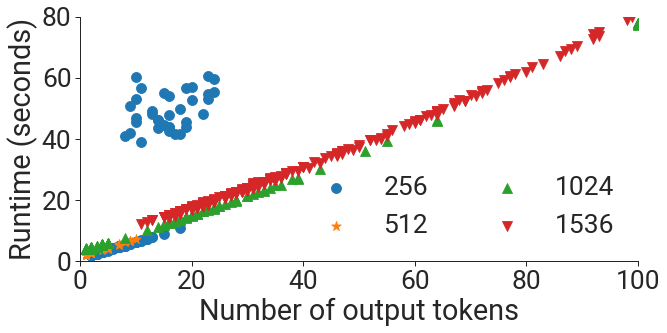

OpenAI/davinci


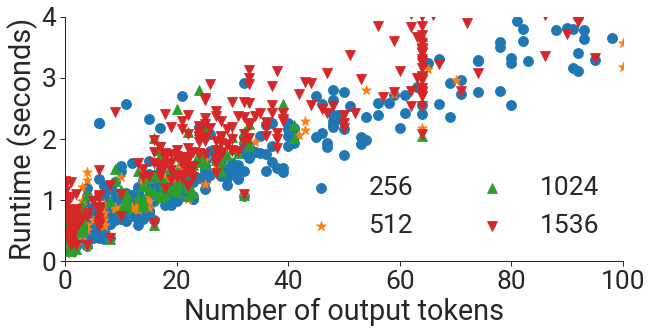

OpenAI/text-davinci-002


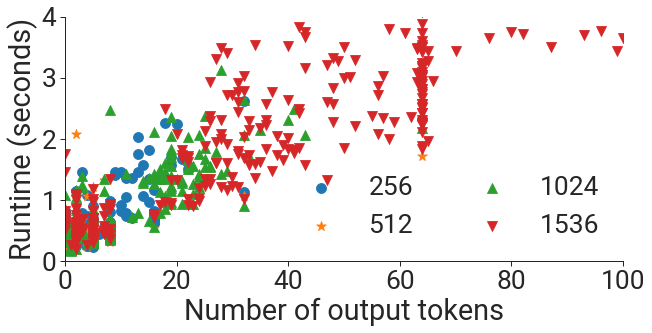

In [7]:
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "AI21/j1-jumbo",
                                      xlim=100, ylim=5,
                                      model_name="ai21_j1-jumbo",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536])
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "AI21/j1-grande",
                                      xlim=100, ylim=3,
                                      model_name="ai21_j1-grande",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536])
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "AI21/j1-large",
                                      xlim=100, ylim=2,
                                      model_name="ai21_j1-large",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536])
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "Anthropic",
                                      xlim=100, ylim=10,
                                      model_name="anthropic_stanford-online-all-v4-s3",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536])
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "MT-Turing-NLG",
                                      xlim=100, ylim=80,
                                      model_name="microsoft_TNLGv2_530B",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536])
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "OpenAI/davinci",
                                      xlim=100, ylim=4,
                                      model_name="openai_davinci",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536])
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "OpenAI/text-davinci-002",
                                      xlim=100, ylim=4,
                                      model_name="openai_text-davinci-002",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536])

AI21/j1-jumbo


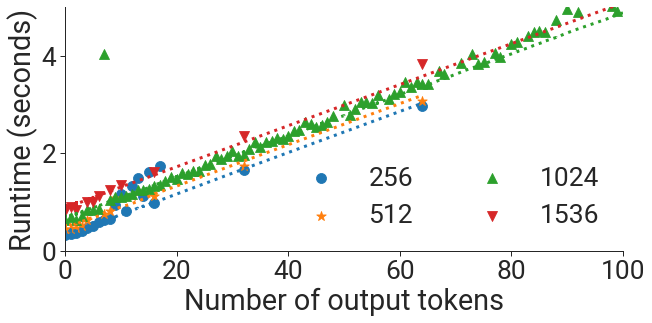

AI21/j1-grande


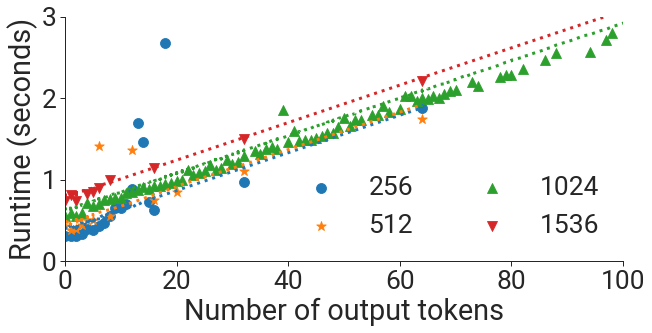

AI21/j1-large


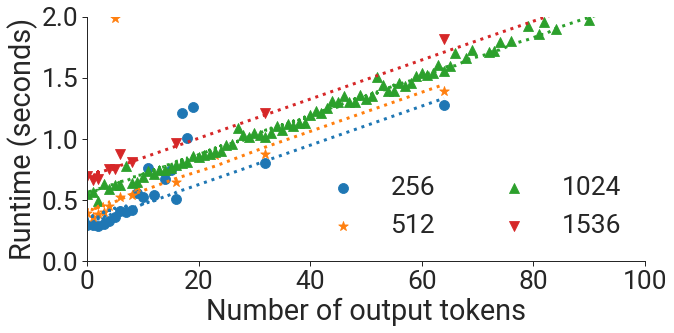

Anthropic


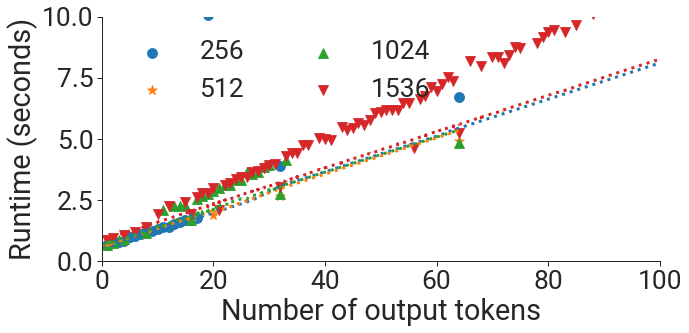

MT-Turing-NLG


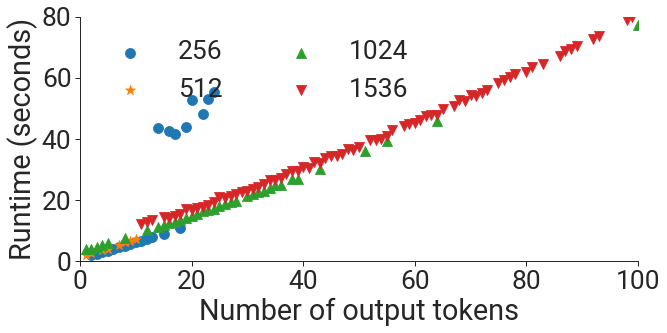

OpenAI/davinci


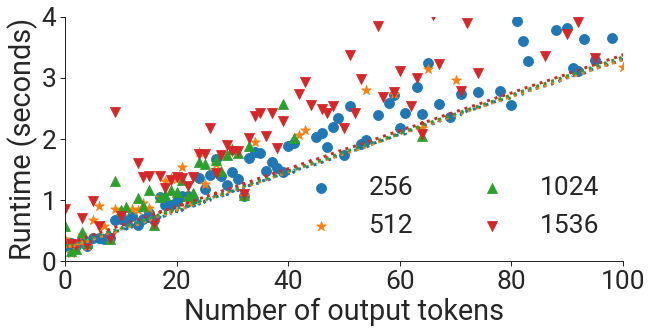

OpenAI/text-davinci-002


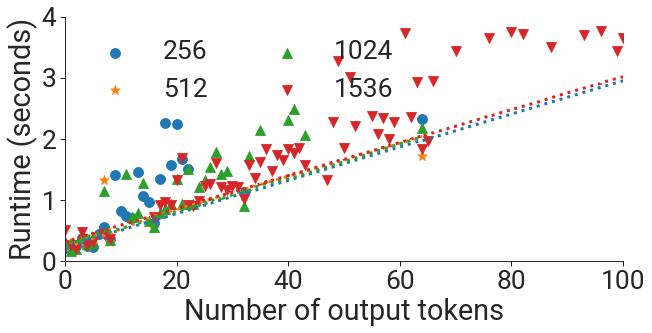

In [8]:
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "AI21/j1-jumbo",
                                      xlim=100, ylim=5,
                                      model_name="ai21_j1-jumbo",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536],
                                      plot_only_minimum=True,
                                      denoised_runtimes_dict=denoised_runtimes_dict_reduced)
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "AI21/j1-grande",
                                      xlim=100, ylim=3,
                                      model_name="ai21_j1-grande",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536],
                                      plot_only_minimum=True,
                                      denoised_runtimes_dict=denoised_runtimes_dict_reduced)
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "AI21/j1-large",
                                      xlim=100, ylim=2,
                                      model_name="ai21_j1-large",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536],
                                      plot_only_minimum=True,
                                      denoised_runtimes_dict=denoised_runtimes_dict_reduced)
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "Anthropic",
                                      xlim=100, ylim=10,
                                      model_name="anthropic_stanford-online-all-v4-s3",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536],
                                      plot_only_minimum=True,
                                      denoised_runtimes_dict=denoised_runtimes_dict_reduced)
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "MT-Turing-NLG",
                                      xlim=100, ylim=80,
                                      model_name="microsoft_TNLGv2_530B",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536],
                                      plot_only_minimum=True,
                                      denoised_runtimes_dict=denoised_runtimes_dict_reduced)
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "OpenAI/davinci",
                                      xlim=100, ylim=4,
                                      model_name="openai_davinci",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536],
                                      plot_only_minimum=True,
                                      denoised_runtimes_dict=denoised_runtimes_dict_reduced)
plot_runtime_versus_num_output_tokens(runtimes_dict_reduced, "OpenAI/text-davinci-002",
                                      xlim=100, ylim=4,
                                      model_name="openai_text-davinci-002",
                                      num_prompt_tokens_band=[256, 512, 1024, 1536],
                                      plot_only_minimum=True,
                                      denoised_runtimes_dict=denoised_runtimes_dict_reduced)